# **Horses and Humans Classifier**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.saving import save_model

### **Image Augmentation**

Trained on **a relatively small dataset** $\Rightarrow$ Began to **hit problems classifying some previously unseen images**, such as the mis-categorization of a woman with a horse because the training set did not include any images of people in that pose.

**Solution: Image Augmentation**

- The idea behind this technique is that, as TensorFlow loads your data, it can create additional new data by amending what it has using several transforms.
- Training takes longer because of all the image processing.
- The model’s accuracy may not be as high as it was previously, because previously it was overfitting to a largely uniform set of data.

### **Load the dataset and apply Image Augmentation**

In [2]:
training_dir = 'data/horse-or-human/train/'
validation_dir = 'data/horse-or-human/validation/'

# Image augmentation & rescaling
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   validation_split=0.1, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')  # 10% for validation
test_datagen = ImageDataGenerator(rescale=1/255, 
                                  validation_split=0.1, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')  # No split needed for test set

# Training generator (90% of the data)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset="training",  # Training subset
    shuffle=True,
    seed=42
)

# Validation generator (10% of the training data)
validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    subset="validation",  # Validation subset
    shuffle=True,
    seed=42
)

# Test generator (from the separate validation directory)
test_generator = test_datagen.flow_from_directory(
    validation_dir,  # This should be your actual test set directory
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Verify dataset sizes
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 925 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Training samples: 925
Validation samples: 102
Test samples: 256


**The model architecture**

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit(train_generator, epochs=2)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.5150 - loss: 1.4334
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6405 - loss: 0.6673


**Visualize the result**

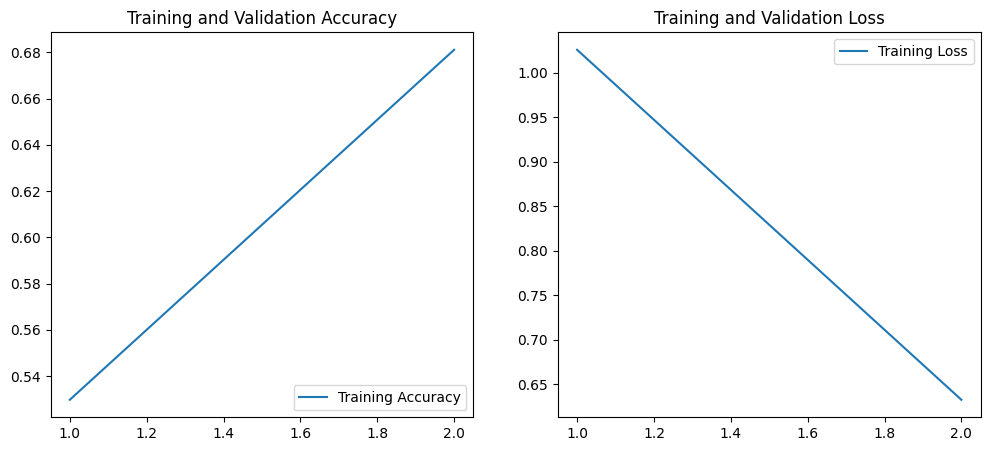

In [7]:
# Extract history data
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

**Predict**

In [8]:
predictions = model.predict(validation_generator)
predicted_classes = (predictions > 0.5).astype("int")  # Convert probabilities to binary labels

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

print(class_labels)

# Map predicted classes to labels
predicted_labels = [class_labels[i] for i in predicted_classes.flatten()]

# Get image filenames
filenames = validation_generator.filenames  # List of image file names

# Print results
for filename, label in zip(filenames, predicted_labels):
    print(f"{filename}: {label}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
['horses', 'humans']
horses\horse01-0.png: horses
horses\horse01-1.png: horses
horses\horse01-2.png: humans
horses\horse01-3.png: horses
horses\horse01-4.png: humans
horses\horse01-5.png: horses
horses\horse01-6.png: horses
horses\horse01-7.png: horses
horses\horse01-8.png: horses
horses\horse01-9.png: horses
horses\horse02-0.png: horses
horses\horse02-1.png: horses
horses\horse02-2.png: humans
horses\horse02-3.png: humans
horses\horse02-4.png: horses
horses\horse02-5.png: horses
horses\horse02-6.png: humans
horses\horse02-7.png: horses
horses\horse02-8.png: horses
horses\horse02-9.png: horses
horses\horse03-0.png: humans
horses\horse03-1.png: humans
horses\horse03-2.png: horses
horses\horse03-3.png: horses
horses\horse03-4.png: horses
horses\horse03-5.png: humans
horses\horse03-6.png: horses
horses\horse03-7.png: horses
horses\horse03-8.png: horses
horses\horse03-9.png: horses
horses\horse04-0.png: humans
horses\horse04-1.png: horses
horses\horse04-

In [9]:
true_classes = validation_generator.classes  

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Prediction Accuracy: {accuracy:.2%}")  

Prediction Accuracy: 48.04%


**Save models**

In [10]:
save_model(model, "horses-and-humans-image-augmentation.keras")
